XGBoost is a state-of-the-art machine learning algorithm that excels in classification and regression tasks due to its high accuracy, computational efficiency, scalability, and robustness. Its ability to handle large datasets, support for parallel processing, and built-in feature importance analysis make it a superior choice compared to other algorithms. XGBoost is renowned for its high accuracy and has consistently outperformed other machine learning algorithms in various predictive modeling tasks, including many Kaggle competitions. XGBoost stands for "Extreme Gradient Boosting" and is an open-source software library that provides a regularizing gradient boosting framework.

In this notebook, I implement XGBoost with python using scikit-learn to solve a simple classification problem. The goal is to predict the classification of the variable 'class' that signifies the evaulation level of a car based on its input variables in four categories: unacceptable, acceptable, good and very good.

The initial model has an accuracy of 0.81 which is improved to 0.96 by hyperparameter tuning using GridSearchCV. To test the model's robustness we apply k-fold cross validation and find satisfactory results. I also calculate feature importance for each feature used to train the model to gain a better intuition of its working.


In [52]:
pip install ucimlrepo

In [53]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline
from ucimlrepo import fetch_ucirepo
import scipy.stats as stats
from statsmodels.graphics.mosaicplot import mosaic

warnings.filterwarnings('ignore')

In [54]:
# fetching dataset
dataset = fetch_ucirepo(id=19)

df = dataset.data.original
df

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc
...,...,...,...,...,...,...,...
1723,low,low,5more,more,med,med,good
1724,low,low,5more,more,med,high,vgood
1725,low,low,5more,more,big,low,unacc
1726,low,low,5more,more,big,med,good


Extracting the features and target variable from the dataset

In [55]:
# Accessig the data (as pandas dataframes)
X = dataset.data.features
y = dataset.data.targets

# Exploratory Data analysis

In [56]:
# Basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [57]:
df.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


In [58]:
# Checking for NULL values
df.isnull().sum()

buying      0
maint       0
doors       0
persons     0
lug_boot    0
safety      0
class       0
dtype: int64

We notice that there are no NULL values present in the dataset.

We also notice that all the variables are of object type, thus we cannot use methods such as Peasons correlation and instead opt for Chi-square test.

In [59]:
# Defining a function for the chi-square test

def chi2_test(df, col1, col2):
    contingency_table = pd.crosstab(df[col1], df[col2])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    return chi2, p, dof, ex

In [60]:
# Converting all the variables into categorical type

df = df.apply(lambda x: x.astype('category') if x.dtype == 'object' else x)

In [61]:
# Perform Chi-squared test with the output variable 'class' for each columns

def chi2_test(df, col1):
    contingency_table = pd.crosstab(df[col1], df["class"])
    chi2, p, dof, ex = stats.chi2_contingency(contingency_table)
    return chi2, p, dof, ex

In [62]:
# Variable to store the columns
columns = df.columns

# DataFrame to store results
results = []

In [63]:
# Performing Chi-squared test for each pair of columns

for col1 in columns:
        if col1 != 'class':
            chi2, p, dof, ex = chi2_test(df, col1)
            results.append((col1, col2, chi2, p))

In [64]:
# Printing out relations that are statistically significant

def interpret_results(results, alpha=0.05):
    for col1, col2, chi2, p in results:
        if p < alpha:
            print(f'Significant association between {col1} and {col2}:')
            print(f'  Chi2: {chi2:.4f}, p-value: {p:.4e}')

# Interpret results with a significance level of 0.05
interpret_results(results)

Significant association between buying and class:
  Chi2: 189.2430, p-value: 5.9281e-36
Significant association between maint and class:
  Chi2: 142.9405, p-value: 2.5477e-26
Significant association between persons and class:
  Chi2: 371.3367, p-value: 4.0400e-77
Significant association between lug_boot and class:
  Chi2: 53.2820, p-value: 1.0294e-09
Significant association between safety and class:
  Chi2: 479.3224, p-value: 2.3892e-100


The output provides us with the Chi-Square statistic and the P-values for the varibales that have significant relations with the output variable "class".

# Feature Engineering


We convert the dataset into an optimized data structure designed to optimize both memory and computational efficiency called Dmatrix. It specialized internal data structure used by XGBoost's own leanring API.

In this classification problem, the dataset is small, however I believe it is best practice to use DMatrix with all XGBoost algorithms.

In [65]:
X.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
dtype: object

Using OneHotEncoder from SKlearn library to transform the categorical data.

In [66]:
from sklearn.preprocessing import OneHotEncoder

#Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Apply one-hot encoding to the columns
X_encoded = encoder.fit_transform(X)
y_encoded = encoder.fit_transform(y)

In [67]:
# Importing XGBoost
import xgboost as xgb

# define data_dmatrix
data_dmatrix = xgb.DMatrix(data=X_encoded,label=y_encoded,enable_categorical=True)

# Trainign the Model

## Train-Test split
We use train test split from the Scikit-learn library to split the transformed dataset into training set and test set with a ratio of 3:1.

In [68]:
# splitting X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size = 0.25, random_state = 0)

# Training the Model
Initially, we train the model using random parameters and all the features.

In [69]:
# importing XGBOost classifier
from xgboost import XGBClassifier

# declaring the default parameters
params = {
    'max_depth': 4,
    'alpha': 10,
    'learning_rate': 1.0,
    'n_estimators': 100,
}

# Initialize the classifier
xgb_clf = XGBClassifier(**params)

# Fitting the classfier to the training data
xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [70]:
# Making predictions using XGBoost Classifier
y_pred = xgb_clf.predict(X_test)

# Model evalutaion

Checking the accuracy score

In [71]:
# Checking the accuracy score of the model
from sklearn.metrics import accuracy_score

print("XGBoost model accuracy score: {0:0.4f}". format(accuracy_score(y_test,y_pred)))

XGBoost model accuracy score: 0.8194


We get an initial accuracy of 81%

# Hyperparameter tuning
GridSearchCV is implemented from the Scikit-learn library to find the optimal parameters for the model. It exhaustively explores different combinations of hyperparameters to find the best set for a given machine learning model.

In [72]:
from sklearn.model_selection import GridSearchCV

# Defining the hyperparameter grid for the Gridsearch
params_grid = {
    'max_depth': [3,5,7],
    'alpha': [0,5,10],
    'learning_rate': [0.1, 0.3, 0.5, 0.7, 1],
    'n_estimators': [50, 100, 150, 200]
}

# Creating the GridSearchCV object
grid_search = GridSearchCV(xgb_clf, params_grid, cv=5, scoring='accuracy')

# Fitting the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Printing the best set of Hyperparameters and their scores
print('Best set of hyperparameters: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)

Best set of hyperparameters:  {'alpha': 0, 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 50}
Best score:  0.9675972675972675


In [73]:
# importing XGBOost classifier
from xgboost import XGBClassifier

# declaring the default parameters
params_op = {
    'max_depth': 7,
    'alpha': 0,
    'learning_rate': 0.5,
    'n_estimators': 50,
}

# Initialize the classifier
xgb_clf_op = XGBClassifier(**params_op)

# Fitting the classfier to the training data
xgb_clf_op.fit(X_train, y_train)

XGBClassifier(alpha=0, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.5, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

In [74]:
# Checking the accuracy score of the optimized model

y_pred_op = xgb_clf_op.predict(X_test)

print("XGBoost model accuracy score: {0:0.4f}". format(accuracy_score(y_test,y_pred_op)))

XGBoost model accuracy score: 0.9514


With the optimized hyperparameters, we increase the accuracy by 0.14 to 95%

# K-fold Cross Validation
K-fold cross-validation is a resampling technique used to assess the performance of a model. It involves partitioning the dataset into 'k' equal-sized folds and then using these folds as separate training and validation sets iteratively 'k' number of times. This approach provides a more realistic estimate of the model's generalization performance, as it uses all observations for both training and validation.


In [75]:
from xgboost import cv

xgb_cv = cv(dtrain=data_dmatrix, params=params_op, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

In [76]:
print(xgb_cv)

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0         0.257151        0.000644        0.265702       0.005076
1         0.177742        0.004750        0.194496       0.005951
2         0.141346        0.006489        0.166885       0.011045
3         0.117506        0.006730        0.154616       0.011057
4         0.101746        0.001476        0.147167       0.009647
5         0.088594        0.002776        0.140423       0.011530
6         0.079529        0.003133        0.138407       0.012291
7         0.070890        0.002121        0.136510       0.011615
8         0.063477        0.001910        0.135125       0.009988
9         0.057695        0.001697        0.133891       0.008653


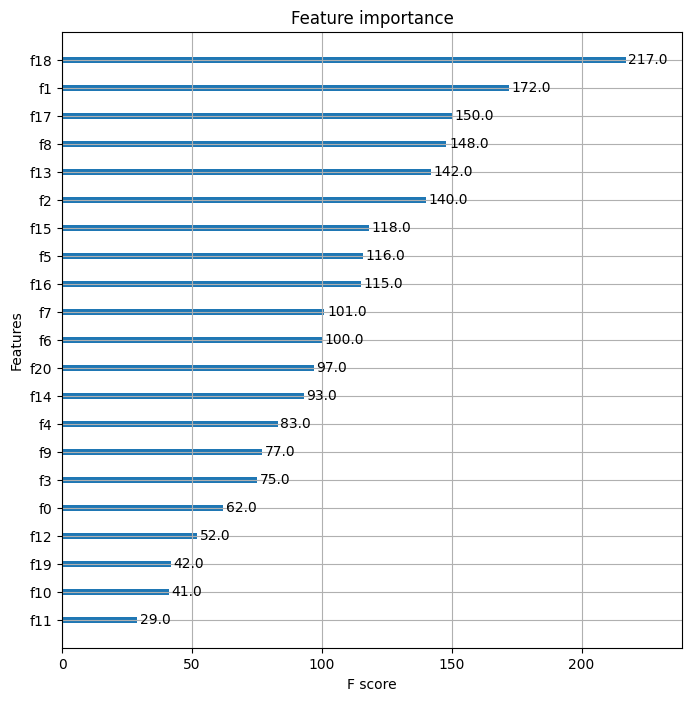

In [77]:
# Plottig  a bar graph for feature importance
xgb.plot_importance(xgb_clf_op)
plt.rcParams['figure.figsize'] = [8, 8]
plt.show()

In the graph, we observe 21 features coz there are 6 categorical variables with toatl 21 levels